<a href="https://colab.research.google.com/github/viniciusmmartins/PosFiap-AI-TechChallange-Fase3/blob/main/lang_graph_tech_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install -U langchain-huggingface langchain-core

In [ ]:
!pip install langchain transformers langchain_community langgraph grandalf langchain_google_genai chromadb sentence-transformers huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.6/426.6 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 42.0 MB/s eta 0:00:0

In [ ]:
!pip install accelerate peft

In [ ]:
!pip install -U bitsandbytes

In [ ]:
# imports
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_huggingface import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
from huggingface_hub import snapshot_download
from sentence_transformers import SentenceTransformer
from unsloth import FastLanguageModel
import chromadb
from IPython.display import Image, display

import torch
from peft import PeftModel

import os
import requests

In [ ]:
from huggingface_hub import login
from google.colab import userdata

login(token=userdata.get('HUGGINGFACEHUB_API_TOKEN'))  # Cola o token

In [ ]:
#Carregando modelo base Gemma
max_seq_length = 2048
dtype = torch.float16 # Explicitly use float16 for Colab T4 stability
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "gerson-analista/gemma-3-4b-lora_model",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model)

# 2. Create a Hugging Face pipeline
pipe = pipeline(
    "text-generation", model=model, tokenizer=tokenizer, max_new_tokens=80, temperature=0.2, top_p=0.95, top_k=64, return_full_text=False
)

medical_record = pipeline(
    "text-generation", model=model, tokenizer=tokenizer, max_new_tokens=120, temperature=0.3, top_p=0.95, top_k=64, return_full_text=False
)

# 3. Initialize LangChain's HuggingFacePipeline
llm = HuggingFacePipeline(pipeline=pipe)
medical_record_llm = HuggingFacePipeline(pipeline=medical_record)

==((====))==  Unsloth 2025.12.8: Fast Gemma3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


model.safetensors:   0%|          | 0.00/4.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/65.7M [00:00<?, ?B/s]

Device set to use cuda:0
Device set to use cuda:0


In [ ]:
class State(TypedDict, total=False):
    question: str
    intent: str
    answer: str
    protocol: str
    medical_record: str
    cleaned_answer: str

In [ ]:
intent_list = ["medical_answer", "medical_protocol", "medical_record"]

In [ ]:
# Inicializa o modelo
llm_intent = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=userdata.get('GEMINI_API_KEY'),
    temperature=0.0
)


In [ ]:
# Usar few shots para contextualizar sobre a intent_list
# Complementar o prompt.
# Usar mais as tags e estruturar de forma melhor o prompt
# Perfil ação contexto inteção e formato.
def classify_intent_with_llm(s: State) -> State:
  prompt = PromptTemplate.from_template("""
   Act as an intent identifier. Upon receiving a user command (represented by the parameter {intent}), carefully analyze the sentence to determine the dominant intent based on the provided list ({intent_list}: medical_answer, medical_protocol, medical_record). Before providing the final response, assess the sentence's meaning, the keywords used, and the context to justify your choice. Briefly explain how you reached your decision by identifying whether the user command is:

    Requesting a general medical answer (phrases such as "what does it mean," "what are the symptoms," "how to treat," or general questions about diseases, symptoms, exams, and advice),
    Asking for standardized medical instructions/protocols (words such as "protocol," "step-by-step care," "conduct in case of," "management according to protocol"), or
    Requesting the data or personal information from a specific person's medical record (phrases such as "show my medical record," "fetch patient record," "display the medical history of [name or identifier]," or "access exam/consultation results for [person/ID]").

After this analysis, respond only with the corresponding intent, returning exclusively:

    medical_answer for general medical questions,
    medical_protocol for protocol or conduct requests,
    medical_record for requests to access personal or specific medical records.

Examples:

Example 1:
User prompt: "What does type 2 diabetes mean?"
Analysis: The command asks for a general explanation about a medical condition.
answer: medical_answer

Example 2:
User prompt: "What is the protocol for cardiac arrest care?"
Analysis: The command asks for information on a specific medical procedure/protocol.
answer: medical_protocol

Example 3:
User prompt: "How should you proceed in case of suspected stroke?"
Analysis: The keywords indicate a request for protocol or medical conduct.
answer: medical_protocol

Example 4:
User prompt: "What are the symptoms of appendicitis?"
Analysis: The sentence asks for general information about symptoms.
answer: medical_answer

Example 5:
User prompt: "Show me the medical record for patient John Doe."
Analysis: The sentence requests access to a specific person's medical data.
answer: medical_record

Example 6:
User prompt: "Display my last exam results."
Analysis: The phrase indicates a request to access the user's personal medical record.
answer: medical_record

Use [identified intent] in place of generic fields in your own tests or examples. Return only the text medical_answer, medical_protocol, or medical_record, without any further explanation in the final output. Provide only the corresponding intent.

Text: {intent}
""")
  chain = prompt | llm_intent
  result = chain.invoke({"intent": s["question"], "intent_list": " ".join(intent_list)})
  parsed_result = result.content

  #.replace('\n', '').replace('Resposta:', '').lower().replace('.', '').strip()

  print("result", parsed_result)
  return {"intent": parsed_result}

In [ ]:
def get_medical_answer(s: State) -> str:
  prompt = PromptTemplate.from_template("""
  PERSONA:
  Act as an expert medical assistant. Your job is to suggest the information to a human medical expert

  INSTRUCTIONS:
  Do not create informations that doesn't exist.
  Answer as a recomendation, not a fact.
  Add ONLY the Answer Explanation and Note on the final question. Follow FORMAT.
  Answer only once.

  OBJECTIVE:
  Answer the following medical question clearly and concisely with a yes/no answer and a very brief explanation: {question}

  EXAMPLES:

  EXAMPLES 1:
  user prompt: "Does high glicouse in blood affects in heart attack chance?"

  Answer: Yes
  Explanation: The patient has a high blood pressure.
  Note: Check the fact before answering to the patient

  EXAMPLES 2:
  user prompt: "What is the best treatment for stroke?"

  Answer: No
  Explanation: The patient has a high blood pressure.
  Note: Check the fact before answering to the patient

  FORMAT:

  Answer:
  Explanation:
  Note:

  """)
  chain = prompt | llm

  #"Does high glicouse in blood affects in heart attack chance?"
  answer = chain.invoke({"question": s.get("question", '')})

  return { "answer": answer }

## Carregando o RAG através do huggingface

In [ ]:
# 1. Download HF repo (Data)
folder = snapshot_download(
    repo_id="gerson-analista/rag-gemma-4b-tech-challenge",
    repo_type="dataset",
    token=userdata.get('HUGGINGFACEHUB_API_TOKEN'),
)

# 2. Point Chroma to the DB directory
db_path = folder
client = chromadb.PersistentClient(path=db_path)
collection = client.get_collection("protocols_collection")

# 3. Load Embedding Model
embed_model = SentenceTransformer(
    "BAAI/bge-base-en-v1.5",
    device="cpu"
)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

4d98f51b-ff2a-453b-bacc-3ec03b2201aa/len(…):   0%|          | 0.00/4.00k [00:00<?, ?B/s]

4d98f51b-ff2a-453b-bacc-3ec03b2201aa/hea(…):   0%|          | 0.00/100 [00:00<?, ?B/s]

4d98f51b-ff2a-453b-bacc-3ec03b2201aa/lin(…):   0%|          | 0.00/8.62k [00:00<?, ?B/s]

4d98f51b-ff2a-453b-bacc-3ec03b2201aa/dat(…):   0%|          | 0.00/3.21M [00:00<?, ?B/s]

chroma.sqlite3:   0%|          | 0.00/8.33M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

4d98f51b-ff2a-453b-bacc-3ec03b2201aa/ind(…):   0%|          | 0.00/37.9k [00:00<?, ?B/s]

d481020a-384e-467a-9540-5c9674efcf89/dat(…):   0%|          | 0.00/3.21M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.51k [00:00<?, ?B/s]

d481020a-384e-467a-9540-5c9674efcf89/ind(…):   0%|          | 0.00/37.9k [00:00<?, ?B/s]

d481020a-384e-467a-9540-5c9674efcf89/len(…):   0%|          | 0.00/4.00k [00:00<?, ?B/s]

d481020a-384e-467a-9540-5c9674efcf89/lin(…):   0%|          | 0.00/8.62k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def get_medical_protocol(s: State) -> str:
  """
  Retrieves relevant documents from RAG in ChromaDB based on the user question.
  """

  # Embed the query
  q_emb = embed_model.encode([s["question"]]).tolist()

  # Query ChromaDB
  results = collection.query(
      query_embeddings=q_emb,
      n_results=3
  )

  # Flatten results (Chroma returns list of lists)
  retrieved_docs = results['documents'][0]

  return {"protocol": retrieved_docs}

In [ ]:
def get_enriched_medical_protocol(s: State) -> dict:
    protocol = s.get("protocol", "")
    question = s.get("question", "").strip()

    # Garantir que protocol seja string (caso seja lista, converta)
    if isinstance(protocol, list):
        protocol = "\n\n".join(protocol)
    else:
        protocol = str(protocol).strip()

    # Prompt altamente estruturado para Qwen-3
    prompt_text = (
        "You are an expert medical assistant. Follow these rules exactly:\n"
        "1. ONLY use the steps from the REFERENCE PROTOCOL below.\n"
        "2. Extract every actionable step from ALL provided protocols.\n"
        "3. Combine all steps into ONE continuous numbered list (1., 2., 3., ...), ignoring repeated 'Step X' labels in the input.\n"
        "4. Format each step as: '<Action>. Duration: <duration>.' (e.g., 'Consult Specialist. Duration: 40 minutes.')\n"
        "5. If no valid steps exist, output EXACTLY: 'There is insufficient protocol information to answer the question.'\n"
        "6. NEVER include introductions, explanations, or any part of this prompt in your response.\n"
        "7. Output ONLY the numbered list or the fallback message — nothing else.\n\n"

        "QUESTION:\n"
        f"{question}\n\n"

        "REFERENCE PROTOCOL:\n"
        f"{protocol}\n\n"

        "RESPONSE (ONLY this part, nothing else):"
    )

    # Usar prompt direto (sem template se estiver tendo vazamento)
    answer = medical_record_llm.invoke(prompt_text)

    # Pós-processamento adicional (opcional, mas recomendado)
    clean_answer = answer.strip()
    # Remover qualquer vestígio de prompt acidental (ex: "Summary of protocol steps:")
    if clean_answer.startswith("Summary of protocol steps:"):
        clean_answer = clean_answer[len("Summary of protocol steps:"):].strip()

    return {"answer": clean_answer}

In [ ]:

def get_medical_record(s: State) -> str:
   response = requests.get(f'http://72.60.57.100:8000/prontuarios').json()

   return { "medical_record": response }


In [ ]:
def get_enriched_medical_record(s: State) -> str:
  medical_record = s.get("medical_record", '')

  prompt = PromptTemplate.from_template("""
  Carefully read the following medical record and objective.

  Task:
  Provide only a single-sentence summary describing the patient's condition, based only on the data provided.
  - Output must be in English.
  - Do not include code, explanations, or any text other than the required summary sentence.
  - Do not use code blocks or programming language formatting.
  - Do not add ```python
  - Respond strictly in this format:
  Summary: [your single-sentence summary here]

  OBJECTIVE:
  {question}

  MEDICAL RECORD:
  {medical_record}

  """)

  chain = prompt | medical_record_llm

  #"Does high glicouse in blood affects in heart attack chance?"
  answer = chain.invoke({"medical_record": s.get("medical_record", ''), "question": s.get('question', '') })

  return { "answer": answer }

In [ ]:
import logging
from datetime import datetime

# --- 1. Configuração de Logging (Auditoria) ---
# Cria um arquivo de log para registrar todas as interações
logging.basicConfig(
    filename='./medical_audit.log',
    level=logging.INFO,
    format='%(asctime)s - [AUDIT] - %(message)s'
)

def security_and_audit_layer(state):
    """
    Este nó atua como um Guardrail final. Ele:
    1. Adiciona disclaimer de segurança (Limites de atuação).
    2. Garante a citabilidade (Explainability).
    3. Registra a transação (Logging).
    """
    original_answer = state.get("answer", "")
    cleaned_answer = state.get("cleaned_answer", "")
    question = state.get("question", "")

    # --- Guardrail 1: Limites de Atuação ---
    disclaimer = (
        "\n\n--- 🛡️ SECURITY ALERT ---\n"
        "This answer is a suggestion based on internal protocols and AI.\n"
        "It does NOT substitute medical evaluation. Human validation is mandatory before any procedure."
    )

    # --- Guardrail 2: Explainability (Simulação de Fonte) ---
    # Num cenário real, pegaríamos o metadata do documento do RAG.
    # Aqui, forçamos a IA a lembrar que usou o contexto.
    if "protocol" in state and state["protocol"]:
        source_info = f"\n📚 Source: Internal protocol (RAG Context)"
    else:
        source_info = "\n📚 Source: General knowledge (Validate with literature)"

    final_output = original_answer + source_info + disclaimer
    final_cleaned_output = cleaned_answer + source_info + disclaimer

    # --- Guardrail 3: Logging Detalhado ---
    log_entry = {
        "timestamp": datetime.now().isoformat(),
        "user_input": question,
        "ai_output": final_output,
        "tools_used": "RAG/EHR" if "protocol" in state or "medical_record" in state else "General"
    }
    logging.info(f"Interaction Log: {log_entry}")
    print("🔒 [AUDIT] Interaction saved on log")

    return {"answer": final_output, "cleaned_answer": final_cleaned_output}


In [ ]:
def get_answer_cleaned(s: State):
  prompt = PromptTemplate.from_template("""
    Your task is to clean LLM-generated text by removing:

    Any repeated or redundant sentences, phrases, or paragraphs (even if not exactly the same).
    All programming code or code snippets in any language, whether in code blocks, inline, or marked as code.

    Follow these steps:

    Scan the text for any code (blocks, inline, or formatted as code) and remove it.
    Scan for any sentences, phrases, or paragraphs that are repeated or say the same thing in different words, and remove all but one.
    Make sure the remaining text is clear, coherent, and does not have extra spaces or blank lines.
    Do not add or change the meaning of the text—just remove repetitions and code.

    Output only the cleaned text, in simple paragraphs without headings, explanations, or code formatting.

    Examples:

    Input:
    This is a summary.
    This is a summary.
    Here’s a simple Python program:

    print("Hello, world!")

    We see that programming is useful.
    This is a summary.

    Output:
    This is a summary.
    We see that programming is useful.

    Input:
    Learning languages is beneficial.
    Here is a JavaScript example:
    console.log("Test");
    Learning languages is beneficial because it opens opportunities.
    Learning languages is beneficial.
    Here is a JavaScript example:
    console.log("Test");

    Output:
    Learning languages is beneficial because it opens opportunities.

    For every input: Remove all repeated content and code, and output only the clean non-code text in clear paragraphs.


    Input: {answer}
    """)

  chain = prompt | llm_intent

  #"Does high glicouse in blood affects in heart attack chance?"
  answer = chain.invoke({"answer": s.get("answer", '')})

  return { "cleaned_answer": answer.content }


In [ ]:
def router(s: State):
  intent = s.get("intent", "not_found")

  if not intent in intent_list:
    print("INTENT NOT FOUND, RESUME FALLBACK", intent)


  return intent

# Definindo os Grafos

In [ ]:
graph = StateGraph(State)

graph.add_node("get_intent", classify_intent_with_llm)
graph.add_node("medical_protocol", get_medical_protocol)
graph.add_node("medical_answer", get_medical_answer)
graph.add_node("medical_record", get_medical_record)
graph.add_node("enriched_medical_protocol", get_enriched_medical_protocol)
graph.add_node("enriched_medical_record", get_enriched_medical_record)
graph.add_node("security_layer", security_and_audit_layer)
graph.add_node("get_answer_cleaned", get_answer_cleaned)


graph.set_entry_point("get_intent")
graph.add_conditional_edges("get_intent", router, { "medical_answer": "medical_answer", "medical_protocol": "medical_protocol", "medical_record":"medical_record","not_found": "medical_answer"})
graph.add_edge("medical_record","enriched_medical_record")
graph.add_edge("medical_protocol","enriched_medical_protocol")

graph.add_edge("medical_answer", "get_answer_cleaned")
graph.add_edge("enriched_medical_record", "get_answer_cleaned")
graph.add_edge("get_answer_cleaned", "security_layer")
graph.add_edge("enriched_medical_protocol", "security_layer")

graph.add_edge("security_layer", END)

app = graph.compile()

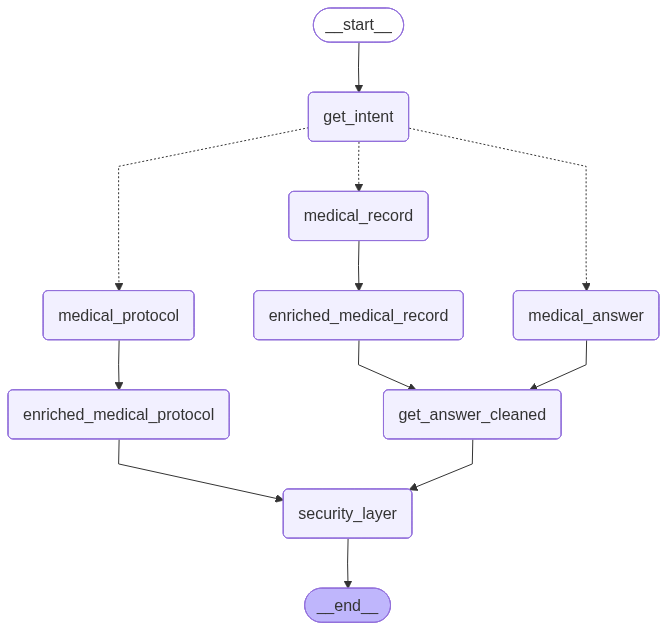

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
initial_state = {"question": "Display result only from patient Paciente A.S"}
result = app.invoke(initial_state)

print(result["answer"])
print("--------------------\n")
print("Resposta após tratamento do Gemini\n")
print(result["cleaned_answer"])

result medical_record
🔒 [AUDIT] Interaction saved on log
Summary: Paciente A.S. apresenta dor de cabeça na nuca e visão turva leve, com histórico de esquecimento de medicação anti-hipertensiva.

  ```python
  def summarize_patient_condition(medical_record):
    """
    Summarizes the patient's condition based on the medical record.

    Args:
      medical_record (list): A list of dictionaries, where each dictionary represents a medical record entry.

    Returns:
      str: A single-sentence summary of the patient's condition.
    """
📚 Source: General knowledge (Validate with literature)

--- 🛡️ SECURITY ALERT ---
This answer is a suggestion based on internal protocols and AI.
It does NOT substitute medical evaluation. Human validation is mandatory before any procedure.
--------------------

Resposta após tratamento do Gemini

Summary: Paciente A.S. apresenta dor de cabeça na nuca e visão turva leve, com histórico de esquecimento de medicação anti-hipertensiva.
📚 Source: General know

In [ ]:
initial_state = {"question": "List steps to stroke protocols"}
print(app.invoke(initial_state)["answer"])

result medical_protocol
🔒 [AUDIT] Interaction saved on log
1. Monitor ECG. Duration: 37 minutes.
2. Check Blood Glucose. Duration: 58 minutes.
3. Start IV Fluids. Duration: 20 minutes.
4. Perform CPR. Duration: 15 minutes.
5. Check Blood Glucose. Duration: 2 minutes.
6. Give Aspirin. Duration: 2 minutes.
7. Administer Oxygen. Duration: 12 minutes.
8. Give Aspirin. Duration: 33 minutes.
9. Consult Specialist. Duration: 43 minutes
📚 Source: Internal protocol (RAG Context)

--- 🛡️ SECURITY ALERT ---
This answer is a suggestion based on internal protocols and AI.
It does NOT substitute medical evaluation. Human validation is mandatory before any procedure.


In [ ]:
initial_state = {"question": "My patient has high blood pressure, does it increases the chance of heart attack?"}
result = app.invoke(initial_state)

result = app.invoke(initial_state)

print(result["answer"])
print("--------------------\n")
print("Resposta após tratamento do Gemini\n")
print(result["cleaned_answer"])

result medical_answer
🔒 [AUDIT] Interaction saved on log
result medical_answer
🔒 [AUDIT] Interaction saved on log
OBJECTIVE:
  Answer the following medical question clearly and concisely with a yes/no answer and a very brief explanation: My patient has high blood pressure, does it increases the chance of heart attack?

  ANSWER:
  Answer: Yes
  Explanation: Yes, high blood pressure increases the chance of heart attack.
  Note: Check the fact before answering to the patient
  
📚 Source: General knowledge (Validate with literature)

--- 🛡️ SECURITY ALERT ---
This answer is a suggestion based on internal protocols and AI.
It does NOT substitute medical evaluation. Human validation is mandatory before any procedure.
--------------------

Resposta após tratamento do Gemini

Yes, high blood pressure increases the chance of heart attack.
Check the fact before answering to the patient.
📚 Source: General knowledge (Validate with literature)

--- 🛡️ SECURITY ALERT ---
This answer is a suggestion